In [36]:
import librosa
import python_speech_features as psf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train = pd.read_csv('Train.csv')
train.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [7]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


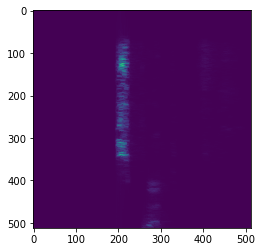

In [8]:
def im_from_audio(fn, sample_rate=44100, window_length=0.05, window_step=0.0045, NFFT=2205):
  
  # Load the audio into an array (signal) at the specified sample rate
  signal, sr = librosa.load(fn, sr=sample_rate)

  # preemphasis
  signal = psf.sigproc.preemphasis(signal, coeff=0.95)

  # get specrogram
  # Get the frames
  frames = psf.sigproc.framesig(signal, 
                                  window_length*sample_rate, 
                                  window_step*sample_rate, 
                                  lambda x:np.ones((x,)))        # Window function 
    
  # magnitude Spectrogram
  spectrogram = np.rot90(psf.sigproc.magspec(frames, NFFT))
  
  # get rid of high frequencies
  spectrogram = spectrogram[512:,:]

  # normalize in [0, 1]
  spectrogram -= spectrogram.min(axis=None)
  spectrogram /= spectrogram.max(axis=None)        

  # Clip to max 512, 512
  spectrogram = spectrogram[:512, :512]
  
  return spectrogram 

# View the resultant image
plt.imshow(im_from_audio(train.fn.sample().values[0]))

In [9]:
im_from_audio(train.fn.sample().values[0]).shape

(512, 512)

In [34]:
from fastai.vision.all import *

def get_x(fn):

    # Use our function from earlier
    spectrogram = im_from_audio(fn) # a 2D array

    # Pad to make sure it is 512 x 512
    w, h = spectrogram.shape
    spectrogram = np.pad(spectrogram, [(0, 512-w), (0, 512-h)])
    
    # Scale to (0, 255)
    spectrogram  -= spectrogram.min()
    spectrogram *= 255.0/spectrogram.max()

    # Make it uint8
    im_arr = np.array(spectrogram, np.uint8)
    

    # Make it rgb (hint - some fun tricks you can do here!)
    r = im_arr
    g = im_arr
    b = im_arr

    return np.stack([r, g, b], axis=-1)

In [35]:
get_x(train.fn.sample().values[0])

(512, 512)


array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 4,  4,  4],
        [ 5,  5,  5],
        [10, 10, 10]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 7,  7,  7],
        [ 6,  6,  6],
        [ 2,  2,  2]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 7,  7,  7],
        [ 5,  5,  5],
        [ 3,  3,  3]]], dtype=uint8)

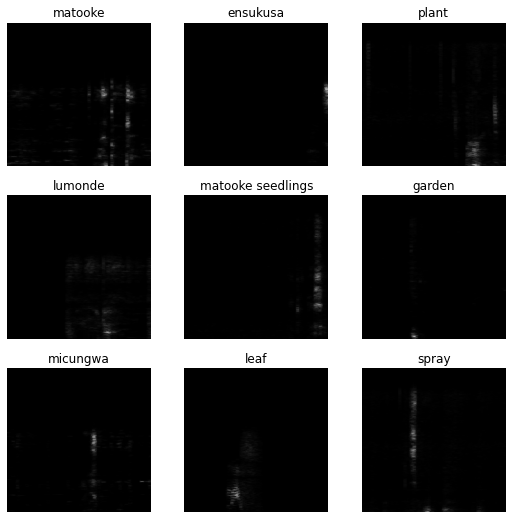

In [33]:
def get_y(fn):
    return train.loc[train.fn == fn].label.values[0]

def get_fns(_):
    return train['fn']

# And build the datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_fns,
    get_x=get_x,
    get_y=get_y, 
    splitter=RandomSplitter(valid_pct=0.1),
    batch_tfms=aug_transforms(do_flip=False, p_affine=0, size=224) # Augment with lighting changes but NOT flips or warps
)
dls = dblock.dataloaders(Path(''), bs=32)
dls.show_batch()

In [11]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, top_k_accuracy])
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,7.043001,6.044329,0.009091,0.036364,00:19


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.704934,5.752736,0.018182,0.100000,00:19
1,4.972853,5.377312,0.036364,0.118182,00:19
2,4.148774,5.238823,0.045455,0.127273,00:19


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=6.309573450380412e-07)

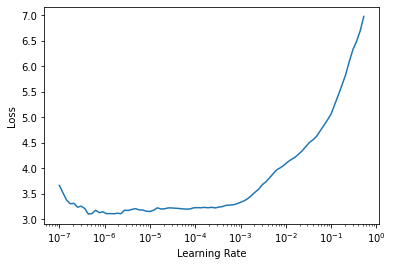

In [18]:
learn.lr_find(suggestions=True)

In [19]:
learn.fit_one_cycle(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.190671,5.173702,0.054545,0.136364,00:18
1,3.121170,5.292143,0.045455,0.118182,00:18
2,3.014237,5.291515,0.027273,0.127273,00:18
3,3.006058,5.204118,0.027273,0.145455,00:18
4,2.885885,5.511030,0.036364,0.081818,00:18
5,2.555433,5.145837,0.072727,0.209091,00:18
6,2.247273,5.126091,0.036364,0.218182,00:18
7,1.958268,5.187501,0.063636,0.145455,00:18
8,1.647867,4.948631,0.081818,0.218182,00:18
9,1.372178,4.875313,0.081818,0.209091,00:18


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.3182567499825382e-06)

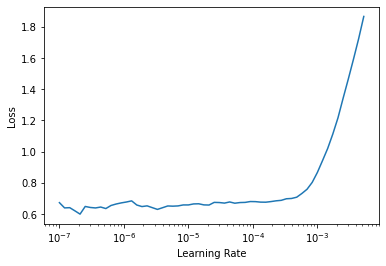

In [20]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [22]:
learn.fit_one_cycle(3, slice(1e-7))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.667874,4.884436,0.090909,0.200000,00:18
1,0.651558,4.912364,0.090909,0.218182,00:18
2,0.648927,4.897904,0.109091,0.209091,00:18
3,0.641929,4.918287,0.090909,0.209091,00:18
4,0.639070,4.894212,0.090909,0.190909,00:18
5,0.650807,4.874516,0.090909,0.209091,00:18
6,0.687981,4.901456,0.090909,0.200000,00:18
7,0.672815,4.907608,0.100000,0.209091,00:18
8,0.661411,4.910586,0.100000,0.200000,00:18
9,0.643661,4.899327,0.090909,0.200000,00:18


In [26]:
tdl = learn.dls.test_dl(ss['fn'].values, order=True) # Create a test dataloader
test_preds, test_labels = learn.get_preds(dl=tdl) # Make the predictions

In [27]:
dls.vocab # The class names

(#193) ['Pump','Spinach','abalimi','afukirira','agriculture','akammwanyi','akamonde','akasaanyi','akatunda','akatungulu'...]

In [28]:
ss.to_csv('Submission_logn.csv', index=False)